# Data

### Libraries

In [1]:
# import libraries

import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/lia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/lia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/lia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Data preparation

In [2]:
def load_filtered_data(city):
    '''
    Load filtered data from a city
    '''
    file = ['business', 'checkin', 'review', 'tip', 'user']
    data = {}
    for f in file:
        data[f] = pd.read_csv(f'../filtered_cities/{city}_{f}.csv')
    return data

In [3]:
# load data

city = 'Springfield'
data = load_filtered_data(city)

In [4]:
# review data

data['review'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11686 entries, 0 to 11685
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    11686 non-null  object
 1   user_id      11686 non-null  object
 2   business_id  11686 non-null  object
 3   stars        11686 non-null  int64 
 4   useful       11686 non-null  int64 
 5   funny        11686 non-null  int64 
 6   cool         11686 non-null  int64 
 7   text         11686 non-null  object
 8   date         11686 non-null  object
dtypes: int64(4), object(5)
memory usage: 821.8+ KB


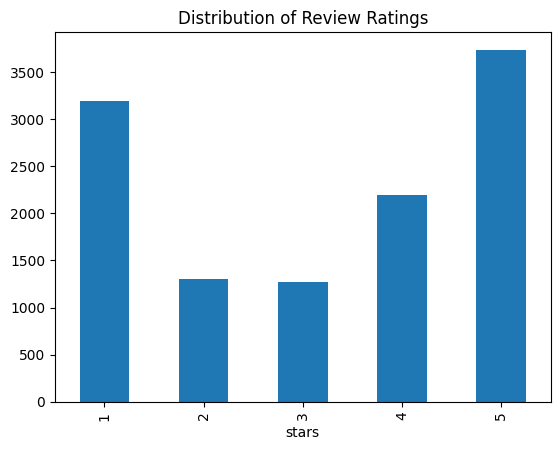

In [5]:
# distribution of review ratings

data['review']['stars'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Review Ratings')
plt.show()

In [6]:
def sentiment(rating):
    '''
    Return sentiment value based on rating (-1 for negative, 0 for neutral, 1 for positive)
    '''
    if rating == 1 or rating == 2:
        return -1
    elif rating == 3:
        return 0
    elif rating == 4 or rating == 5:
        return 1

In [7]:
# dataframe with reviews and sentiment values (based on stars)

reviews = data['review'].copy()
reviews['sentiment'] = reviews['stars'].apply(sentiment)
review_df = reviews[['review_id', 'text', 'sentiment']]

review_df

,review_id,text,sentiment
0,LLzom-2TITa4gasV7_fCCA,Great experience purchasing a washer and dryer...,1
1,a5JHzBrWxRd_OmIvV7znDA,Went here based on the high ratings and raves ...,-1
2,X-o--dwf0HuFMittYi4wCA,"oh Millers, how i wanted to like you. You are...",-1
3,INGNbsyo-MouZZzcxnCSGQ,This place gets two stars from me only because...,-1
4,k7VatXVLism-cTDJE8TTUw,"This place was awesome. Clean, beautiful and t...",1
...,...,...,...
11681,IlU-MQzMKc7jAHWwK5VFGQ,"To be fair, I tried them in their first week. ...",0
11682,Qt3BsRvQuJccDQfFWM1XPw,Awful place. It's dirty. Had two birthday part...,-1
11683,3CQQ8Im_UX6QqDECuXYK8A,A truly vegetarian delight! I took a Jewish f...,1
11684,ery1nBM7zKweFLBe-bT5ag,I have a 2011 Toyota Sienna Limited. During th...,-1


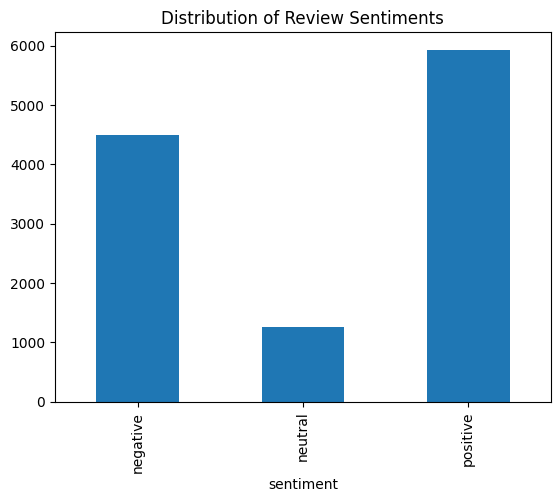

In [8]:
# distribution of sentiment values

review_df['sentiment'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Review Sentiments')
plt.xticks(ticks=[0, 1, 2], labels=['negative', 'neutral', 'positive'])
plt.show()

In [9]:
# save review data

review_df.to_csv(f'data/review_sentiment.csv', index=False)

### Text processing

In [10]:
# see content of reviews

for review in review_df['text'].head(5).values:
    print('-' * 50)
    print(review)

--------------------------------------------------
Great experience purchasing a washer and dryer.  I just bought a new home and needed all new appliances. Iam so glad I decided to go even though the reviews were not great which I don't understand since I had no issues whatsoever. There was an excellent selection, knowledgeable salespeople and timely delivery. The level of service we received was beyond expected! I really felt like they were working hard to give me the best price and offered many options to stay in my budget  They even took the time to check if there were any additional sales prices or discounts they could offer me. I was given honest feedback and all of my questions were answered. I am very happy with Sears and I would highly recommend!
--------------------------------------------------
Went here based on the high ratings and raves from people.  The entire experience was underwhelming from start to finish.  Their website which is fairly useless if you want to figure o

In [11]:
# common negation words

negation_words = ["don't", "no", "none", "never", "nowhere", "neither", "nor", "not", "cannot","didn't", "couldn't", "wouldn't", "won't", "can't", "aren't", "isn't", "wasn't", "haven't", "hasn't", "hadn't"]

In [51]:
def process_review(text, lemmatizer, sw, negation_handling=True):
    '''
    Process a review text by removing non-alphabetic characters, converting to lowercase, removing stopwords, and stemming
    '''
    text = re.sub('[^a-zA-Z!\']', ' ', text)
    text = re.sub('!', ' ! ', text)
    text = text.lower()
    words = text.split()

    words = [lemmatizer.lemmatize(word) for word in words]

    if negation_handling:
        for i in range(len(words)):
            if words[i] in negation_words and i < len(words) - 1:
                words[i+1] = 'NOT_' + words[i+1]
    
    words = [word for word in words if word not in negation_words]
    words = [word for word in words if word not in sw]

    text = ' '.join(words)
    return text

In [52]:
# stemmer and stopwords

ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
sw = set(stopwords.words('english'))

In [55]:
# text processing

corpus = []
corpus_negative = []
corpus_neutral = []
corpus_positive = []

for i in range(0, review_df['text'].size):
    review = process_review(review_df['text'][i], lemmatizer, sw)
    corpus.append(review)
    sentiment = review_df['sentiment'][i]
    if sentiment == -1:
        corpus_negative.append(review)
    elif sentiment == 0:
        corpus_neutral.append(review)
    elif sentiment == 1:
        corpus_positive.append(review)

great experience purchasing washer dryer bought new home needed new appliance iam glad decided go even though review NOT_great NOT_understand since NOT_issue whatsoever wa excellent selection knowledgeable salesperson timely delivery level service received wa beyond expected ! really felt like working hard give best price offered many option stay budget even took time check additional sale price discount could offer wa given honest feedback question answered happy sears would highly recommend !


In [15]:
# see content of processed reviews

for review in corpus[:5]:
    print('-' * 50)
    print(review)

In [16]:
# save corpus data

with open('data/corpus.txt', 'w') as f:
    for review in corpus:
        f.write(review + '\n')

### Wordclouds

In [17]:
# global word cloud

wordcloud = WordCloud().generate(" ".join(corpus))

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

ValueError: We need at least 1 word to plot a word cloud, got 0.

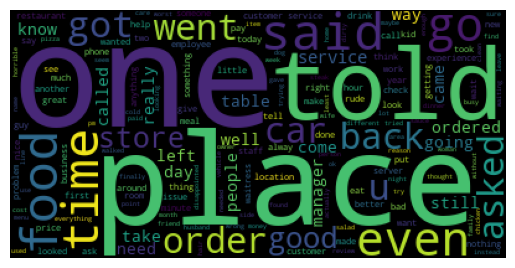

In [ ]:
# word cloud for negative reviews

wordcloud = WordCloud().generate(" ".join(corpus_negative))

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

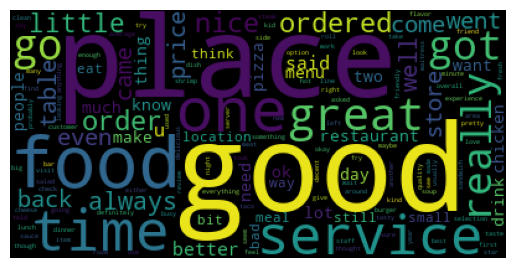

In [ ]:
# word cloud for neutral reviews

wordcloud = WordCloud().generate(" ".join(corpus_neutral))

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

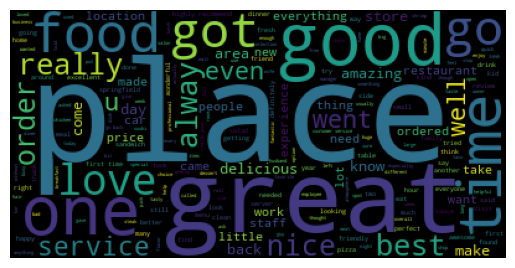

In [ ]:
# word cloud for positive reviews

wordcloud = WordCloud().generate(" ".join(corpus_positive))

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Frequency distributions

In [ ]:
# frequency distribution of words

all_words = ' '.join(corpus).split()
fd = nltk.FreqDist(all_words)

negative_words = ' '.join(corpus_negative).split()
fd_negative = nltk.FreqDist(negative_words)

neutral_words = ' '.join(corpus_neutral).split()
fd_neutral = nltk.FreqDist(neutral_words)

positive_words = ' '.join(corpus_positive).split()
fd_positive = nltk.FreqDist(positive_words)

In [ ]:
# most common words in reviews

fd.most_common(10)

[('!', 14451),
 ('time', 5653),
 ('food', 5631),
 ('place', 5498),
 ('good', 5261),
 ('service', 4481),
 ('get', 4366),
 ('one', 4159),
 ('back', 4015),
 ('great', 3972)]

In [ ]:
# most common words in negative reviews

fd_negative.most_common(10)

[('!', 5604),
 ('time', 2715),
 ('get', 2227),
 ('back', 2209),
 ('would', 2186),
 ('food', 2160),
 ('one', 2150),
 ('service', 2024),
 ('place', 2008),
 ('like', 1783)]

In [ ]:
# most common words in neutral reviews

fd_neutral.most_common(10)

[('good', 988),
 ('!', 957),
 ('food', 811),
 ('place', 702),
 ('time', 600),
 ('like', 554),
 ('get', 480),
 ('one', 475),
 ('service', 460),
 ('would', 401)]

In [ ]:
# most common words in positive reviews

fd_positive.most_common(10)

[('!', 7890),
 ('great', 3106),
 ('good', 2933),
 ('place', 2788),
 ('food', 2660),
 ('time', 2338),
 ('service', 1997),
 ('get', 1659),
 ('like', 1551),
 ('one', 1534)]